AIC-201 Predicting 5-Year Mortality in Colorectal Cancer using an Artificial Neural Network Assignment by JOSH

Libaraies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks, Sequential
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
RANDOM_STATE = 42

Explatory data analysis

In [ ]:
df = pd.read_csv('SR386_labels.csv')
df.head()
print("")
df.info()
print("")
print(f"Data Shape: {df.shape}")
print("")
print("\nColumns:", list(df.columns))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 30 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   case_id                                         427 non-null    int64  
 1   died_within_5_years                             425 non-null    float64
 2   days_till_death                                 425 non-null    object 
 3   crc_primary_cause_of_death                      95 non-null     float64
 4   age_at_diagnosis                                427 non-null    int64  
 5   sex                                             427 non-null    object 
 6   site_of_tumour                                  425 non-null    object 
 7   site_of_tumour_grouping                         425 non-null    object 
 8   kras_ex_2                                       427 non-null    object 
 9   kras_ex_3                                 

In [ ]:
df.isnull().sum()

,0
case_id,0
died_within_5_years,2
days_till_death,2
crc_primary_cause_of_death,332
age_at_diagnosis,0
sex,0
site_of_tumour,2
site_of_tumour_grouping,2
kras_ex_2,0
kras_ex_3,0


Data cleaning and pre processing

In [ ]:
target_col = 'died_within_5_years'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset. Available columns: {df.columns.tolist()}")

print("\nTarget value counts:")
print(df[target_col].value_counts(dropna=False))


Target value counts:
died_within_5_years
0.0    264
1.0    161
NaN      2
Name: count, dtype: int64


In [ ]:
df = df.dropna(subset=target_col).copy()
print(df[target_col].value_counts(dropna=False))

died_within_5_years
0.0    264
1.0    161
Name: count, dtype: int64


In [ ]:
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing>0]
print("\nColumns with missing values:\n", missing)


Columns with missing values:
 pM                                                392
crc_primary_cause_of_death                        330
em_lvi_notes                                      221
distance_to_peritoneum_macroscopic_measurement     25
peri_surface_involved                               6
em_lvi                                              3
tumour_type                                         2
differentiation                                     2
pre-op_radio                                        2
site_of_tumour                                      2
site_of_tumour_grouping                             2
pre-op_chemo                                        2
pT                                                  1
stage                                               1
pN                                                  1
stage_subgroup                                      1
dtype: int64


In [ ]:
print("\nNumeric summary:")
display(df.describe())


Numeric summary:


,case_id,died_within_5_years,crc_primary_cause_of_death,age_at_diagnosis,mmr_loss_binary
count,425.000000,425.000000,95.0,425.000000,425.000000
mean,300.865882,0.378824,1.0,67.943529,0.075294
std,168.569210,0.485666,0.0,11.967787,0.264176
min,1.000000,0.000000,1.0,33.000000,0.000000
25%,154.000000,0.000000,1.0,59.000000,0.000000
50%,305.000000,0.000000,1.0,69.000000,0.000000
75%,448.000000,1.000000,1.0,77.000000,0.000000
max,583.000000,1.000000,1.0,97.000000,1.000000


In [ ]:
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nCategorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['days_till_death', 'sex', 'site_of_tumour', 'site_of_tumour_grouping', 'kras_ex_2', 'kras_ex_3', 'kras_codon_117', 'nras_ex_2', 'nras_ex_3', 'braf_mutant_status', 'mmr_ihc', 'primary_metastatic', 'stage', 'stage_subgroup', 'pT', 'pN', 'pM', 'tumour_type', 'differentiation', 'peri_surface_involved', 'distance_to_peritoneum_macroscopic_measurement', 'em_lvi', 'em_lvi_notes', 'pre-op_radio', 'pre-op_chemo']
Numeric columns: ['case_id', 'died_within_5_years', 'crc_primary_cause_of_death', 'age_at_diagnosis', 'mmr_loss_binary']


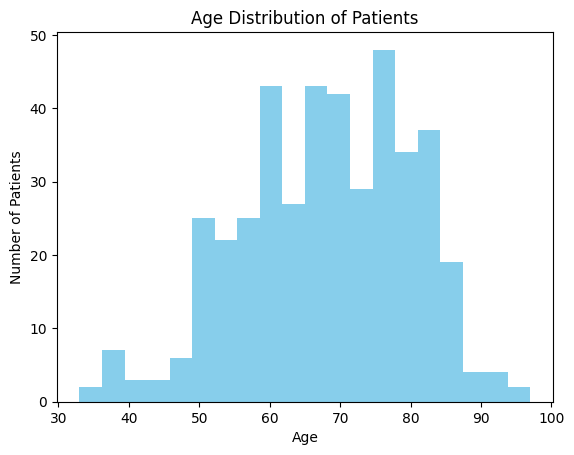

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df['age_at_diagnosis'].dropna(), bins=20, color="skyblue")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.title("Age Distribution of Patients")
plt.show()


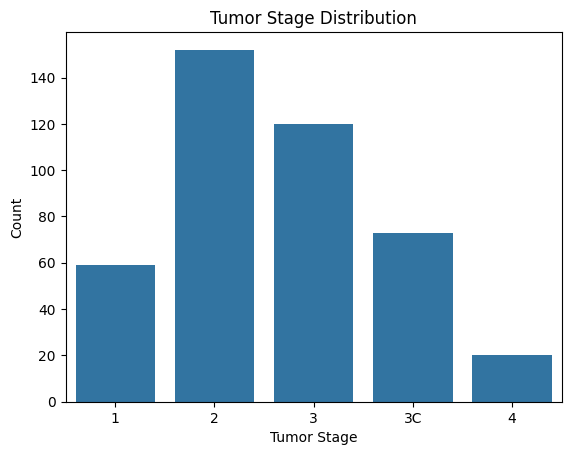

In [ ]:

sns.countplot(x="stage", data=df)
plt.title("Tumor Stage Distribution")
plt.xlabel("Tumor Stage")
plt.ylabel("Count")
plt.show()


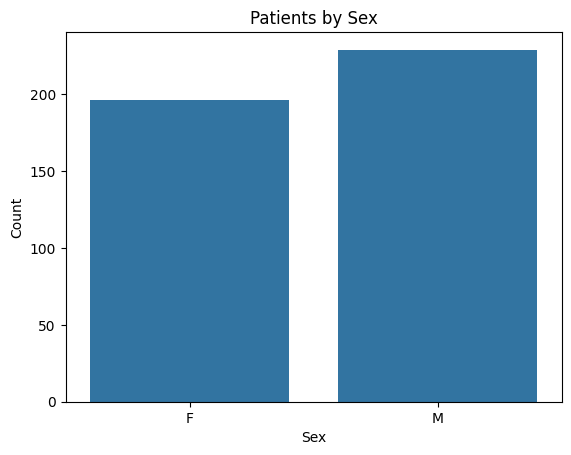

In [ ]:
import seaborn as sns
sns.countplot(x="sex", data=df)
plt.title("Patients by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()


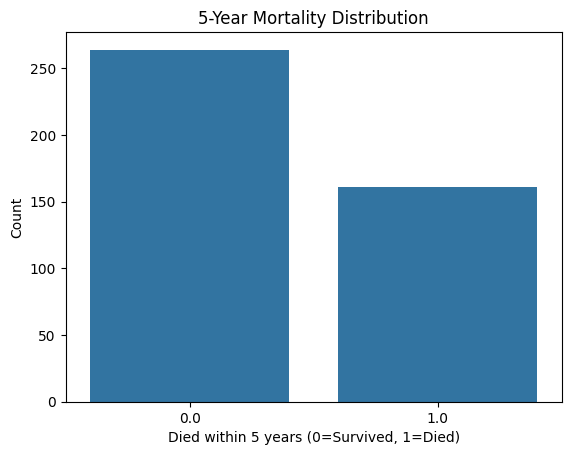

In [ ]:
sns.countplot(x="died_within_5_years", data=df)
plt.title("5-Year Mortality Distribution")
plt.xlabel("Died within 5 years (0=Survived, 1=Died)")
plt.ylabel("Count")
plt.show()

In [ ]:
for x in ['sex','msi_status','tumor_stage','mutation_status']:
    if x in df.columns:
        print(f"\nValue counts for {x}:")
        print(df[x].value_counts(dropna=False))


Value counts for sex:
sex
M    229
F    196
Name: count, dtype: int64


In [ ]:
# Manual columns to drop
drop_cols = ['patient_id','id','sample_id','case_id','days_till_death','distance_to_peritoneum_macroscopic_measurement']
#Drop columns with more than 30% missing values
missing_threshold = 0.3 * len(df)
too_many_missing = [col for col in df.columns if df[col].isnull().sum() > missing_threshold]

# Drop columns with fewer than 5 unique non-null values (excluding NaN)
too_few_unique = [col for col in df.columns if df[col].dropna().nunique() < 5]

# Combine all columns to drop, removing duplicates
to_drop = list(set(drop_cols + too_many_missing + too_few_unique))

# Actually drop columns, making a copy of the cleaned dataframe
df_cleaned = df.drop(columns=to_drop, errors='ignore')
print("Columns dropped:", to_drop)
print("Remaining columns:", df_cleaned.columns.tolist())


Columns dropped: ['died_within_5_years', 'mmr_ihc', 'sex', 'em_lvi_notes', 'mmr_loss_binary', 'patient_id', 'kras_codon_117', 'pM', 'case_id', 'pre-op_radio', 'distance_to_peritoneum_macroscopic_measurement', 'sample_id', 'crc_primary_cause_of_death', 'id', 'days_till_death', 'primary_metastatic']
Remaining columns: ['age_at_diagnosis', 'site_of_tumour', 'site_of_tumour_grouping', 'kras_ex_2', 'kras_ex_3', 'nras_ex_2', 'nras_ex_3', 'braf_mutant_status', 'stage', 'stage_subgroup', 'pT', 'pN', 'tumour_type', 'differentiation', 'peri_surface_involved', 'em_lvi', 'pre-op_chemo']


In [ ]:
drop_cols = []
# common identifier names to drop if found
for candidate in ['patient_id','id','sample_id','case_id','days_till_death']:
    if candidate in df.columns:
        drop_cols.append(candidate)
# Also drop columns that are the same as target or obviously irrelevant (e.g., file paths)
for col in df.columns:
    if 'path' in col.lower() or 'file' in col.lower():
        drop_cols.append(col)
drop_cols = list(set(drop_cols))
print("\nDropping columns (identifiers / irrelevant):", drop_cols)


Dropping columns (identifiers / irrelevant): ['days_till_death', 'case_id']


In [ ]:
# Drop columns with >30% missing values
missing_threshold = int(0.3 * len(df))
drop_missing = [col for col in df.columns if df[col].isnull().sum() > missing_threshold]
df = df.drop(columns=drop_missing)
print("Columns dropped for high missingness:", drop_missing)


Columns dropped for high missingness: ['crc_primary_cause_of_death', 'pM', 'em_lvi_notes']


In [ ]:
df = df.drop(columns=drop_cols)
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

print("\nFeature columns used:", list(X.columns))

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("\nNum features:", num_features)
print("Cat features:", cat_features)


Feature columns used: ['age_at_diagnosis', 'sex', 'site_of_tumour', 'site_of_tumour_grouping', 'kras_ex_2', 'kras_ex_3', 'kras_codon_117', 'nras_ex_2', 'nras_ex_3', 'braf_mutant_status', 'mmr_ihc', 'mmr_loss_binary', 'primary_metastatic', 'stage', 'stage_subgroup', 'pT', 'pN', 'tumour_type', 'differentiation', 'peri_surface_involved', 'distance_to_peritoneum_macroscopic_measurement', 'em_lvi', 'pre-op_radio', 'pre-op_chemo']

Num features: ['age_at_diagnosis', 'mmr_loss_binary']
Cat features: ['sex', 'site_of_tumour', 'site_of_tumour_grouping', 'kras_ex_2', 'kras_ex_3', 'kras_codon_117', 'nras_ex_2', 'nras_ex_3', 'braf_mutant_status', 'mmr_ihc', 'primary_metastatic', 'stage', 'stage_subgroup', 'pT', 'pN', 'tumour_type', 'differentiation', 'peri_surface_involved', 'distance_to_peritoneum_macroscopic_measurement', 'em_lvi', 'pre-op_radio', 'pre-op_chemo']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 425 entries, 0 to 426
Data columns (total 25 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   died_within_5_years                             425 non-null    float64
 1   age_at_diagnosis                                425 non-null    int64  
 2   sex                                             425 non-null    object 
 3   site_of_tumour                                  423 non-null    object 
 4   site_of_tumour_grouping                         423 non-null    object 
 5   kras_ex_2                                       425 non-null    object 
 6   kras_ex_3                                       425 non-null    object 
 7   kras_codon_117                                  425 non-null    object 
 8   nras_ex_2                                       425 non-null    object 
 9   nras_ex_3                                       

Feature Engineering,
Scaling,
Data Preparation

In [ ]:
num_imputer = SimpleImputer(strategy='mean')
X_num = pd.DataFrame(num_imputer.fit_transform(X[num_features]), columns=num_features, index=X.index)

# Impute categorical (most frequent) and then one-hot encode
X_cat = pd.DataFrame(index=X.index)
if len(cat_features)>0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X[cat_features]), columns=cat_features, index=X.index)
    X_cat = pd.get_dummies(X_cat_imp, drop_first=True)
else:
    X_cat = pd.DataFrame(index=X.index)

X_proc = pd.concat([X_num, X_cat], axis=1)
print("\nProcessed feature shape:", X_proc.shape)

# 9) Handle any remaining NaNs
print("Remaining NaNs in processed X:", X_proc.isnull().sum().sum())


Processed feature shape: (425, 246)
Remaining NaNs in processed X: 0


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_proc, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
# From train_full, split 15/85 -> validation 15 overall => val size = 0.1765 of train_full to yield 15% total
val_size = 0.17647058823529413  # exact to get 70/15/15
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

print("\nSplit sizes:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train target distribution:", Counter(y_train))
print("Val target distribution:", Counter(y_val))
print("Test target distribution:", Counter(y_test))


Split sizes:
Train: (297, 246) Val: (64, 246) Test: (64, 246)
Train target distribution: Counter({0: 184, 1: 113})
Val target distribution: Counter({0: 40, 1: 24})
Test target distribution: Counter({0: 40, 1: 24})


In [ ]:
scaler = StandardScaler()

# Scale the processed data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


print("\nFinal feature matrix shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)


Final feature matrix shapes: (297, 246) (64, 246) (64, 246)


In [ ]:
X_train_arr = X_train_scaled
X_val_arr = X_val_scaled
X_test_arr = X_test_scaled
y_train_arr = y_train.values
y_val_arr = y_val.values
y_test_arr = y_test.values

input_dim = X_train_arr.shape[1]
print("Input dimension:", input_dim)

Input dimension: 246


In [ ]:
# Utility: function to build, train, and evaluate a model
def build_and_train(model_builder, epochs=100, batch_size=32, use_class_weight=None, verbose=0):
    model = model_builder(input_dim)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_arr, y_train_arr, validation_data=(X_val_arr, y_val_arr),
                        epochs=epochs, batch_size=batch_size, callbacks=[es], class_weight=use_class_weight, verbose=verbose)
    # Evaluate on test set
    preds_prob = model.predict(X_test_arr).ravel()
    preds = (preds_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_test_arr, preds)
    acc = accuracy_score(y_test_arr, preds)
    prec = precision_score(y_test_arr, preds, zero_division=0)
    rec = recall_score(y_test_arr, preds, zero_division=0)
    f1 = f1_score(y_test_arr, preds, zero_division=0)
    return {'model': model, 'history': history, 'cm': cm, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'preds_prob': preds_prob, 'preds': preds}


Model Building

In [ ]:
# BASELINE MODEL

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        15,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,921 (70.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train_arr, y_train_arr, validation_data=(X_val_arr, y_val_arr), epochs=30, batch_size=16, verbose=1)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4986 - loss: 0.7851 - val_accuracy: 0.6250 - val_loss: 0.6314
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6784 - loss: 0.6372 - val_accuracy: 0.6875 - val_loss: 0.5954
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7495 - loss: 0.5260 - val_accuracy: 0.7031 - val_loss: 0.5600
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7579 - loss: 0.5037 - val_accuracy: 0.7500 - val_loss: 0.5376
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8256 - loss: 0.4359 - val_accuracy: 0.7656 - val_loss: 0.5132
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8346 - loss: 0.3949 - val_accuracy: 0.7812 - val_loss: 0.5024
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8287 - loss: 0.3873 - val_accuracy: 0.7656 - val_loss: 0.5091
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8737 - loss: 0.3302 - val_accuracy: 0.7500 - val_loss

Evaluation


In [ ]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[30 10]
 [11 13]]


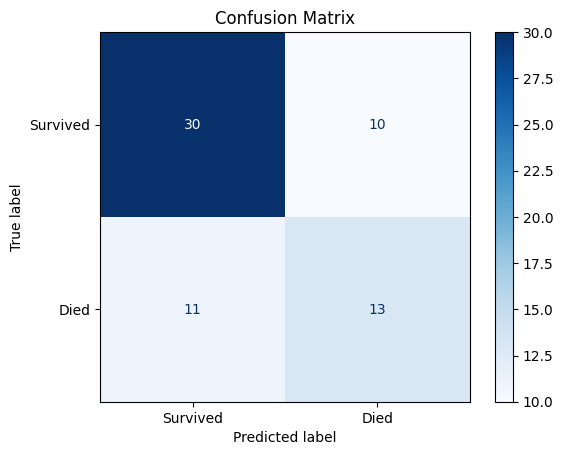

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Survived', 'Died'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.671875
Precision: 0.5652173913043478
Recall: 0.5416666666666666
F1 Score: 0.5531914893617021


## Model Improvements

To improve the performance of the baseline model, several techniques were applied, including:

-   **SMOTE (Synthetic Minority Over-sampling Technique):** To address the class imbalance in the training data.
-   **Class Weights:** To give more importance to the minority class during training.
-   **L2 Regularization:** To prevent overfitting by adding a penalty to the model's weights.
-   **Early Stopping and ReduceLROnPlateau Callbacks:** To stop training when the validation loss stops improving and to reduce the learning rate when the validation loss plateaus.

Fine Tuning


In [ ]:
#Class weights

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.8070652173913043), 1: np.float64(1.3141592920353982)}


In [ ]:
#Regularization
from keras import regularizers

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # define input properly
    keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
#Learning rate of Adam
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)  # slower learning rate


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
#Accurazy, precision and recall
from tensorflow.keras.metrics import Precision, Recall

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [ ]:
#CallBacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),  # stop early
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),  # save best
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)  # halve LR if no improvement
]

# Scale the resampled data
X_resampled_scaled = scaler.transform(X_resampled)

history = model.fit(X_resampled_scaled, y_resampled,
                    validation_data=(X_val_arr, y_val_arr),
                    epochs=50,
                    batch_size=16,
                    class_weight=class_weights,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4235 - loss: 1.7438 - precision: 0.4305 - recall: 0.3065 - val_accuracy: 0.5938 - val_loss: 1.4194 - val_precision: 0.4688 - val_recall: 0.6250 - learning_rate: 5.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5060 - loss: 1.5166 - precision: 0.4945 - recall: 0.5926 - val_accuracy: 0.4844 - val_loss: 1.3773 - val_precision: 0.3902 - val_recall: 0.6667 - learning_rate: 5.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5127 - loss: 1.4271 - precision: 0.5190 - recall: 0.6428 - val_accuracy: 0.5000 - val_loss: 1.3477 - val_precision: 0.4167 - val_recall: 0.8333 - learning_rate: 5.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5968 - loss: 1.2758 - precision: 0.5868 - recall: 0.7839 - val_accuracy: 0.5469 - val_loss: 1.3126 - val_precision: 0.4490 - val_recall: 0.9167 - learning_rate: 5.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - 

Evaluation

In [ ]:
y_pred = model.predict(X_test_arr)
y_pred_classes = (y_pred > 0.5).astype(int)  # For binary classification (0/1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print("Test Accuracy:", accuracy_score(y_test_arr, y_pred_classes))
print("Test Precision:", precision_score(y_test_arr, y_pred_classes))
print("Test Recall:", recall_score(y_test_arr, y_pred_classes))
print("Test F1-Score:", f1_score(y_test_arr, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_test_arr, y_pred_classes))
print("Classification Report:\n", classification_report(y_test_arr, y_pred_classes))

Test Accuracy: 0.65625
Test Precision: 0.5416666666666666
Test Recall: 0.5416666666666666
Test F1-Score: 0.5416666666666666
Confusion Matrix:
 [[29 11]
 [11 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72        40
           1       0.54      0.54      0.54        24

    accuracy                           0.66        64
   macro avg       0.63      0.63      0.63        64
weighted avg       0.66      0.66      0.66        64



In [ ]:
import numpy as np
print("Predicted mortality rate over 5 years:", np.mean(y_pred_classes))
print("Number predicted to die:", np.sum(y_pred_classes))
print("Number predicted to survive:", len(y_pred_classes) - np.sum(y_pred_classes))

Predicted mortality rate over 5 years: 0.375
Number predicted to die: 24
Number predicted to survive: 40


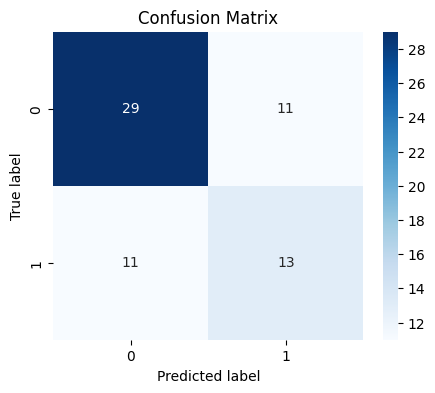

In [ ]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion Matrix")
plt.show()



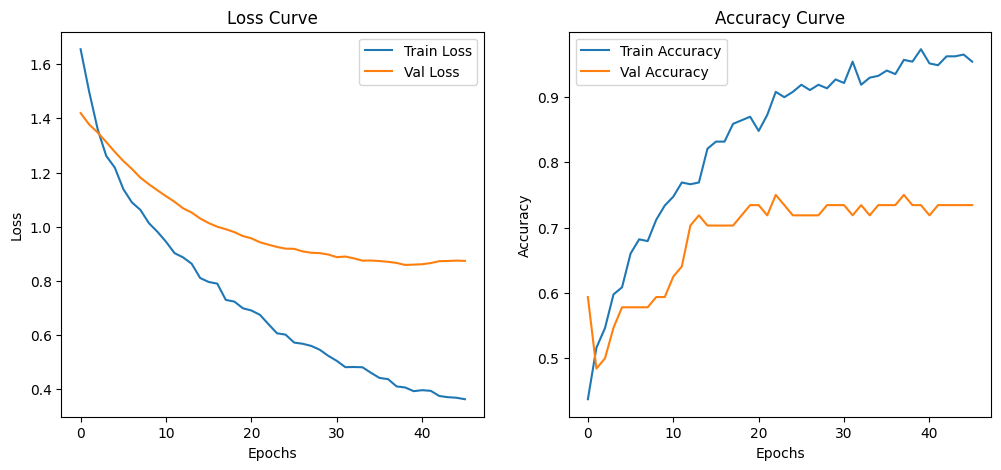

In [ ]:
# Loss and accuracy curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


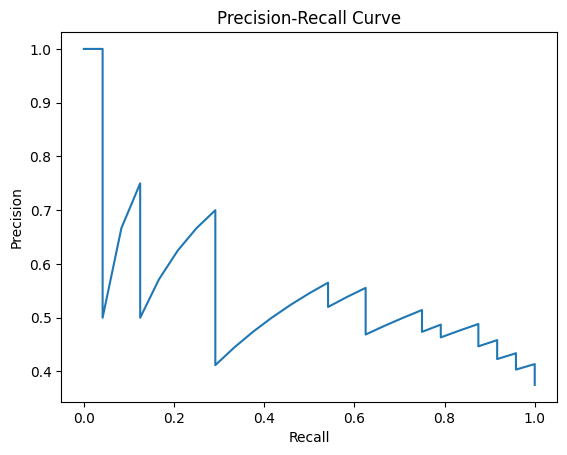

In [ ]:
from sklearn.metrics import precision_recall_curve

y_proba = model.predict(X_test_arr)
precision, recall, thresholds = precision_recall_curve(y_test_arr, y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

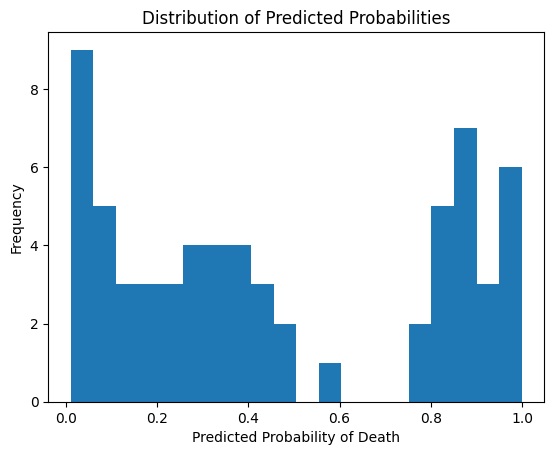

In [ ]:
plt.hist(y_pred, bins=20)
plt.xlabel('Predicted Probability of Death')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

The model achieved around 67% accuracy and balanced precision–recall performance. In a medical setting, recall is more critical than precision since missing patients who might die (false negatives) could have serious consequences. However, the model still needs improvement before any clinical deployment due to modest performance.

EDA: Age Distribution Most patients are aged 60–75, suggesting that age could be an important risk factor. Further analysis may help clarify its predictive value.